# Swiss Housing Price Predictor 🏠💰

Hello, we are Tobias, Sascha, and Florian. Our goal for this project is to build a predictive model for Swiss housing prices. We aim to achieve this by leveraging current web data. 

![Family house during golden hour.](resources\Peach-Tree-House.png)
<br><small>[Image Source](https://archivaldesigns.com/collections/all/products/peach-tree-ii-house-plan?view=new2), Retrieved April 29, 2024</small>


This project will involve several steps:

1. **Data Collection**: Scrape housing data from various online sources.
2. **Preprocessing**: Clean and format the data for analysis.
3. **Exploratory Data Analysis**: Understand the data and find any interesting trends.
4. **Feature Engineering**: Create new features from the existing data to improve our model's performance.
5. **Model Building**: Train a machine learning model on our processed data.
6. **Evaluation**: Test our model's performance and make any necessary adjustments.

Our aim is that our model will be able to accurately predict housing prices, providing valuable insights for both buyers and sellers in the Swiss housing market. 

You can check out our code [here on GitHub](https://github.com/meichflo/ADS_Project_group3).

> "The only way to do great work is to love what you do." - Steve Jobs

### Imports

In [1]:
# %pip install googlemaps # not needed if requirements.txt is used

In [2]:
# Libraries
import os
import re
import json
import ast
import time
import random
import pandas as pd
import numpy as np
import folium
import googlemaps

from bs4 import BeautifulSoup

from prettytable import from_csv

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from datetime import datetime

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.support.ui import WebDriverWait
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.support import expected_conditions as EC

# Settings
import warnings
warnings.filterwarnings("ignore")

# Current working directory
print(f'Current working directory: {os.getcwd()}')

Current working directory: c:\Users\FMeic\data_science\ADS_Project_group3


# Data Collection
In this phase, we focus on gathering the necessary data for our project. We start by identifying the data sources, which can include databases, APIs, and public datasets. Once we have determined where the data will come from, we proceed with the data acquisition process. This involves collecting the data through various methods such as web scraping, querying databases, or accessing data through APIs.

### Web Scraping from Immoscout24
As part of our data collection efforts for the immo-project, we will be utilizing web scraping techniques to extract relevant information from the swiss immo plattform **Immoscout24**. This will allow us to gather valuable data that will contribute to our project.

In [ ]:
# List of user agents to rotate through
ua_list = ["Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/14.0.3 Safari/605.1.15",
           "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
           "Mozilla/5.0 (Macintosh; Intel Mac OS X 10.15; rv:88.0) Gecko/20100101 Firefox/88.0"]

# Set up the Chrome driver with a random user agent and headless mode
opts = Options()
opts.add_argument("--headless")
opts.add_argument("user-agent=" + random.choice(ua_list))

#service = Service(executable_path=r'C:\Tools\chromedriver\chromedriver.exe')
service = Service(executable_path=r'/Users/tobiaskoller/Library/CloudStorage/OneDrive-ZHAW/2. Semester/Applied Data Science/tools/chromedriver-mac-x64/chromedriver')

# Chrome-Driver
driver = webdriver.Chrome(service=service, options=opts)

# Base URL of the website to scrape
base_url = 'https://www.immoscout24.ch/de/immobilien/mieten/kanton-zuerich?pn='

# Initialize an empty list to store scraped data
all_detail_urls = []


current_page = 1    # Start with page 1 of the search results
max_pages = 50  # Specify the maximum number of pages to scrape

# Loop through all pages to extract URLs of property listings
while current_page <= max_pages:
    driver.get(base_url + str(current_page))     # Load the website
    source = driver.page_source                  # Get the full content of the website
    soup = BeautifulSoup(source, 'html.parser')  # Parse HTML content with BeautifulSoup
    
    # Extract detail page URLs
    listing_links_elements = soup.find_all('a', class_='HgCardElevated_content_uir_2 HgCardElevated_link_EHfr7')
    detail_urls = [link['href'] for link in listing_links_elements if 'href' in link.attrs]
    # Assuming the href might not be a full URL, prepend base URL if needed
    full_urls = ['https://www.immoscout24.ch' + url if not url.startswith('http') else url for url in detail_urls]
    all_detail_urls.extend(full_urls)

    # Increment the page number
    current_page += 1

# Initialize empty lists to store the scraped data
all_detailed_id = []
all_detailed_title = []
all_detailed_address = []
all_detailed_price = []
all_detailed_rooms = []
all_detailed_squareMeters = []
all_detailed_descriptions = [] 
all_detailed_coreAttributes = []
all_detailed_features = []


test_urls = ['https://www.immoscout24.ch/mieten/4000855763', 'https://www.immoscout24.ch/mieten/4000894477']

# Loop through all detail URLs to extract detailed information
for url in all_detail_urls:
    driver.get(url)
    detailed_source = driver.page_source
    detailed_soup = BeautifulSoup(detailed_source, 'html.parser')

    detailed_id = re.search(r'\d+', url).group()

    detailed_title_element = detailed_soup.find('h1', class_='ListingTitle_spotlightTitle_ENVSi')
    detailed_title = detailed_title_element.text.strip() if detailed_title_element else 'No title found'
    all_detailed_title.append(detailed_title)

    detailed_address_element = detailed_soup.find('address', class_='AddressDetails_address_i3koO')
    detailed_address = detailed_address_element.text.strip() if detailed_address_element else 'No address found'
    all_detailed_address.append(detailed_address)

    detailed_price_element = detailed_soup.find('div', class_='SpotlightAttributesPrice_value_TqKGz')
    detailed_price = detailed_price_element.text.strip() if detailed_price_element else 'No price found'
    all_detailed_price.append(detailed_price)

    detailed_rooms_element = detailed_soup.find('div', class_='SpotlightAttributesNumberOfRooms_value_TUMrd')
    detailed_rooms = detailed_rooms_element.text.strip() if detailed_rooms_element else 'No rooms found'
    all_detailed_rooms.append(detailed_rooms)

    detailed_squareMeters_element = detailed_soup.find('div', class_='SpotlightAttributesUsableSpace_value_cpfrh')
    detailed_squareMeters = detailed_squareMeters_element.text.strip() if detailed_squareMeters_element else 'No square meters found'
    all_detailed_squareMeters.append(detailed_squareMeters)

    detailed_description_element = detailed_soup.find('div', class_='Description_descriptionBody_AYyuy')
    detailed_description = detailed_description_element.text.strip() if detailed_description_element else 'No description found'
    all_detailed_descriptions.append(detailed_description)

    detailed_coreAttributes_element = detailed_soup.find('div', class_='CoreAttributes_coreAttributes_e2NAm')
    #detailed_coreAttributes = detailed_coreAttributes_element.text.strip() if detailed_coreAttributes_element else 'No Core Attributes found'
    #all_detailed_coreAttributes.append(detailed_coreAttributes)

    attributes = {}
    if detailed_coreAttributes_element is None:
        all_detailed_coreAttributes.append({'wartning': 'No core attributes found'})
    else:
        for dt, dd in zip(detailed_coreAttributes_element.find_all('dt'), detailed_coreAttributes_element.find_all('dd')):
            key = dt.text.strip(':')
            value = ' '.join(dd.text.split())  # This is to clean up the value, removing extra spaces and newlines
            attributes[key] = value
        all_detailed_coreAttributes.append(attributes)


    features_list = detailed_soup.find('ul', class_='FeaturesFurnishings_list_S54KV')
    features = []
    if features_list is None:
        features.append('No features found')
    else:
        for feature_item in features_list.find_all('li'):
            # Extract the text from the p tag within each li
            feature_text = feature_item.find('p').text.strip()
            features.append(feature_text)
    all_detailed_features.append(features)

    time.sleep(random.uniform(2, 4))

# Close the driver after scraping is done
driver.close()

# Convert the scraped data to a DataFrame
df = pd.DataFrame({
    'Title': all_detailed_title,
    'Address': all_detailed_address,
    'Price': all_detailed_price,
    'Rooms': all_detailed_rooms,
    'SquareMeters': all_detailed_squareMeters,
    'CoreAttributes': all_detailed_coreAttributes,
    'Features': all_detailed_features,
    'Description': all_detailed_descriptions,
    'URL': all_detail_urls
                    })

# Get the current date
current_date = datetime.now().date()

# Add the current date to each entry in the DataFrame
df['Date'] = current_date

csvName = 'immoscout24_zh.csv'

# Save to file
df.to_csv(csvName, sep=";", index=False)

# Show file
with open(csvName) as table_file:
    tab = from_csv(table_file, delimiter=';')
    
    # Set the alignment for all columns to 'l' (left-align)
    for field_name in tab.field_names:
        tab.align[field_name] = 'l'
    
    print(tab)

### Cleansing of Scraped Data

In [8]:
df_cleansing = pd.read_csv('immoscout24_zh_all_20240402.csv', sep=';')
all_coreAttributes_list_strings = df_cleansing['CoreAttributes'].tolist()
all_features_list_strings = df_cleansing['Features'].tolist()
all_features_list = [json.loads(f_strings.replace("'", '"')) for f_strings in all_features_list_strings]


# Price Data Cleansing
def convert_price_to_number(price_str):
    cleaned_price = ''.join([char for char in price_str if char.isdigit()]) # Remove all characters except digits 
    if cleaned_price:
        return int(cleaned_price) # Convert the cleaned string to an integer
    else:
        return None  # Return None or 0 if the price is not found or cannot be converted  
# Apply the function to the 'Price' column
df_cleansing['Price'] = df_cleansing['Price'].apply(convert_price_to_number)


# Square Meters Data Cleansing
def convert_square_meters_to_number(square_meters_str):
    cleaned_square_meters = square_meters_str.replace('m2', '').strip() # Remove 'm2' and any surrounding whitespace
    if cleaned_square_meters.isdigit():
        return int(cleaned_square_meters) # Convert the cleaned string to an integer
    else:
        return None  # Return None or 0 if the square meter is not found or cannot be converted
# Apply the function to the 'SquareMeters' column
df_cleansing['SquareMeters'] = df_cleansing['SquareMeters'].apply(convert_square_meters_to_number)
    
    
# Split Core Attributes Data
def convert_strings_to_dicts(cA_strings):
    converted_cA_dicts = []
    for d in cA_strings:
        try:
            # Attempt to convert string to dictionary
            converted_cA_dict = ast.literal_eval(d)
            converted_cA_dicts.append(converted_cA_dict)
        except Exception as e:
            # Print problematic string and error message
            print("Error converting string:", d)
            print("Error message:", str(e))
    return converted_cA_dicts

# Apply function to convert strings to dictionaries
all_detailed_coreAttributes_list = convert_strings_to_dicts(all_coreAttributes_list_strings)

df_updates = pd.DataFrame(all_detailed_coreAttributes_list)
df_cleansing = pd.concat([df_cleansing, df_updates], axis=1)


# Split Features Data
def get_unique_values(all_detailed_features_input): # Function to get all unique values in the features list
    unique_fatures = set()
    for sublist in all_detailed_features_input:
        for features in sublist:
            unique_fatures.update(sublist)
    return list(unique_fatures)

# Apply function to get all unique values in the 'Features' column
unique_attributes = get_unique_values(all_features_list)

feature_rows_list = []
for array in all_features_list:
    feature_row = {attribute: False for attribute in unique_attributes} # Initialize a row with all empty strings
    # Mark with 'X' all attributes present in the current array
    for attribute in array:
        if attribute in feature_row:
            feature_row[attribute] = True
    # Append the row to the list
    feature_rows_list.append(feature_row)

# Create a DataFrame from the rows_list and then concatenate it with the original df
df_cleansing = pd.concat([df_cleansing, pd.DataFrame(feature_rows_list)], axis=1)

# Drop the original 'CoreAttributes' and 'Features' columns
df_cleansing.drop(['CoreAttributes', 'Features'], axis=1, inplace=True)

# Save the cleansed DataFrame to a new CSV file
df_cleansing.to_csv('immoscout24_zh_cleansed.csv', index=False, sep=';')
print('Data cleansing completed and saved to immoscout24_zh_all_20240402_cleansed.csv')


Error converting string: No core attributes found
Error message: invalid syntax (<unknown>, line 1)
Error converting string: No core attributes found
Error message: invalid syntax (<unknown>, line 1)
Error converting string: No core attributes found
Error message: invalid syntax (<unknown>, line 1)
Data cleansing completed and saved to immoscout24_zh_all_20240402_cleansed.csv


In [10]:
df_cleansing.head()

,Title,Address,Price,Rooms,SquareMeters,Description,URL,Date,Verfügbarkeit,Objekttyp,...,Aussicht,Reduit,No features found,Abwasseranschluss,Swimmingpool,Eckhaus,Kinderfreundlich,Wasseranschluss,Geschirrspüler,In Wohngemeinschaft
0,"""Moderne Wohnung mit einzigartigem Panorama""","Bahnhofweg 1, 8302 Kloten",2570.0,2.5,73.0,"Innovation, Komfort und Weitsicht - Wohnen in ...",https://www.immoscout24.ch/mieten/4000939090,2024-04-02,16.05.2024,Wohnung,...,True,False,False,False,False,False,False,False,False,False
1,"""ACHTUNG: Wohnperle sucht Mieter!""","Herrligweg 9, 8048 Zürich",1921.0,1.5,26.0,"Wohnperle an ruhiger, zentraler Lage sucht Mie...",https://www.immoscout24.ch/mieten/4000598194,2024-04-02,Sofort,Wohnung,...,False,False,False,False,False,False,False,False,False,False
2,"""ERSTVERMIETUNG - ruhig, grün, urban - erstkla...","Poststrasse 47, 8953 Dietikon",2830.0,3.5,104.0,Per Herbst 2024 entstehen insgesamt 39 erstkla...,https://www.immoscout24.ch/mieten/4000895944,2024-04-02,01.10.2024,Wohnung,...,False,False,False,False,False,False,True,False,False,False
3,"""Hochwertig ausgebaute 3.5-Zimmerwohnung - B-1.1""","Im Steinacher 3, 8303 Bassersdorf",2950.0,3.5,90.0,Für Anspruchsvolle: hochwertig ausgebaute 3.5-...,https://www.immoscout24.ch/mieten/4000679565,2024-04-02,Nach Vereinbarung,Wohnung,...,False,False,False,False,False,False,True,False,False,False
4,"""Erstvermietung Neubau Wohnungen an zentraler ...","Widenstrasse 1, 8302 Kloten",2950.0,3.5,92.0,Wir vermieten per 1. Juli 2024 an ruhiger Lage...,https://www.immoscout24.ch/mieten/4000823521,2024-04-02,01.07.2024,Wohnung,...,True,False,False,False,False,False,True,False,False,False


# Data Cleaning and Preprocessing

In [2]:
df_cleansing = pd.read_csv('immoscout24_zh_cleansed.csv', sep=';')

In [3]:
df_cleansing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 59 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Title                    1000 non-null   object 
 1   Address                  1000 non-null   object 
 2   Price                    985 non-null    float64
 3   Rooms                    1000 non-null   object 
 4   SquareMeters             870 non-null    float64
 5   Description              996 non-null    object 
 6   URL                      1000 non-null   object 
 7   Date                     1000 non-null   object 
 8   Verfügbarkeit            997 non-null    object 
 9   Objekttyp                997 non-null    object 
 10  Anzahl Zimmer            872 non-null    float64
 11  Etage                    751 non-null    object 
 12  Anzahl Etagen            134 non-null    float64
 13  Wohnfläche               873 non-null    object 
 14  Baujahr                  

In [4]:
df_cleansing['Address'].isna().sum()


0

#### What if the Price is missing? 
There is nothing to do with the data if the label is missing. Hence, we have to delete the row

In [5]:
df_cleansing['Price'].isna().sum()

15

In [6]:
# Drop rows with missing values in the 'Price' column
df_cleansing = df_cleansing.dropna(subset=['Price'])

### Data Transformation
In the following cells we normalize our data, handle categorical data, and create new variables if necessary. This step is essential for preparing our data for machine learning algorithms, which often require data to be in a specific format.

In [7]:
# Convert 'Rooms' and 'Date' to numeric and datetime, respectively
df_cleansing['Rooms'] = pd.to_numeric(df_cleansing['Rooms'], errors='coerce')
df_cleansing['Date'] = pd.to_datetime(df_cleansing['Date'])
# Convert attributs with missing values to integers
df_cleansing['Anzahl Wohnungen'] = df_cleansing['Anzahl Wohnungen'].fillna(0).astype(int)#df_cleansing['Anzahl Etagen'] = df_cleansing['Anzahl Etagen'].fillna(0).astype(int)
df_cleansing['Anzahl Toiletten'] = df_cleansing['Anzahl Toiletten'].fillna(0).astype(int)
# Convert 'Etage' to numeric, replace 'EG' with 0
df_cleansing['Etage'] = pd.to_numeric(df_cleansing['Etage'].replace('EG', 0))

In [8]:
# remove units from data and convert to numeric
df_cleansing["Wohnfläche"] = df_cleansing["Wohnfläche"].str.replace('m2', '').astype(float)
df_cleansing["Nutzfläche"] = df_cleansing["Nutzfläche"].str.replace('m2', '').astype(float)
df_cleansing["Raumhöhe"] = df_cleansing["Raumhöhe"].str.replace('m', '').astype(float)
df_cleansing["Grundstückfläche"] = df_cleansing["Grundstückfläche"].str.replace('m2', '').astype(float)
df_cleansing["Kubatur"] = df_cleansing["Kubatur"].str.replace('m3', '').astype(float)
df_cleansing["Hallenhöhe"] = df_cleansing["Hallenhöhe"].str.replace('m', '').astype(float)
df_cleansing["Mindestnutzfläche"] = df_cleansing["Mindestnutzfläche"].str.replace('m2', '').astype(float)

In [9]:
df_cleansing.info()

<class 'pandas.core.frame.DataFrame'>
Index: 985 entries, 0 to 999
Data columns (total 59 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Title                    985 non-null    object        
 1   Address                  985 non-null    object        
 2   Price                    985 non-null    float64       
 3   Rooms                    863 non-null    float64       
 4   SquareMeters             862 non-null    float64       
 5   Description              982 non-null    object        
 6   URL                      985 non-null    object        
 7   Date                     985 non-null    datetime64[ns]
 8   Verfügbarkeit            982 non-null    object        
 9   Objekttyp                982 non-null    object        
 10  Anzahl Zimmer            859 non-null    float64       
 11  Etage                    742 non-null    float64       
 12  Anzahl Etagen            132 non-null    

### Data Cleaning
Machine Learning algorithms cannot work with missing features. We must create functions to take care of them. We can see that the i.e. Rooms or Raumhöhe attribute has some missing values. We must fix this. There are three options:
- Get rid of the corresponding districts.
- Get rid of the whole attribute.
- Set the values to some value (zero, the mean, the median, etc.).

##### Hanlde the NaNs

Let's see what we can do with each district:

| Feature                  | How to fill nan?                                              |
|--------------------------|---------------------------------------------------------------|
| Title                    | Remove - Text has no relevance for MLM                                 |
| Date                     | Remove - value with no meaning for price                |
| Description              | Remove - Text has no relevance for MLM                                 |
| URL                      | Remove - Text has no relevance for MLM                                 |
| Anzahl Zimmer            | Remove - redundancy to Rooms                                  |
| Rooms                    | Put mean of the column                                            |
| Verfügbarkeit            | Remove - verry instable value some texts and some dates       |
| Wohnfläche               | Remove - redundancy to SquareMeters                           |
| SquareMeters             | Put Median (80) of the column                                            |
| Anzahl Etagen            | Remove - value with no meaning for appartments                |
| Etage                    | Put groundfloor for all (0)                                       |
| Baujahr                  | Put Median (2013) of the column                                            |
| Raumhöhe                 | Put fix value of 2.50m which is the minimum according to Swiss construction law |
| Letztes Renovationsjahr  | Put 'Baujahr' if empty                                      |
| Nutzfläche               | Remove because there are very few values                       |
| Grundstückfläche         | Remove because there are very few values                       |
| Kubatur                  | Remove because there are very few values                       |
| Anzahl Toiletten         | Put fix value 1                                                              |
| Hallenhöhe               | Remove because there are very few values                       |
| Mindestnutzfläche        | Remove because there are very few values                       |

___
Let's start with removing the respective columns: 


In [10]:
df_cleansing.drop(columns=[
    'Title', 
    'Date', 
    'Description', 
    'URL', 
    'Anzahl Zimmer', 
    'Verfügbarkeit', 
    'Anzahl Etagen', 
    'Nutzfläche', 
    'Grundstückfläche', 
    'Kubatur',  
    'Wohnfläche', 
    'Mindestnutzfläche', 
    'Hallenhöhe'], inplace=True)

In [11]:
# Rooms
print("Number of missing values in 'Rooms':", df_cleansing['Rooms'].isna().sum())
df_cleansing['Rooms'].describe()
df_cleansing['Rooms'].fillna(df_cleansing['Rooms'].mean(), inplace=True)

Number of missing values in 'Rooms': 122


In [12]:
# SquareMeters
print("Number of missing values in 'SquareMeters':", df_cleansing['SquareMeters'].isna().sum()) # Count missing values
df_cleansing['SquareMeters'].fillna(df_cleansing['SquareMeters'].median(), inplace=True) # Fill missing values with the median

Number of missing values in 'SquareMeters': 123


In [13]:
# Etage
print("Number of missing values in 'Etage':", df_cleansing['Etage'].isna().sum()) # Count missing values
df_cleansing['Etage'].fillna(0, inplace=True) # Fill missing values with 0 (ground floor)

Number of missing values in 'Etage': 243


In [14]:
# Raumhöhe
print("Number of missing values in 'Raumhöhe':", df_cleansing['Raumhöhe'].isna().sum()) # Count missing values
df_cleansing['Raumhöhe'].fillna(2.5, inplace=True) # Fill missing values with fixed value according to local standards

Number of missing values in 'Raumhöhe': 895


In [15]:
# Baujahr
print("Number of missing values in 'Baujahr':", df_cleansing['Baujahr'].isna().sum()) # Count missing values
df_cleansing['Baujahr'].fillna(df_cleansing['Baujahr'].median(), inplace=True) # Fill missing values with the median

Number of missing values in 'Baujahr': 499


In [16]:
# Letztes Renovationsjahr
print("Number of missing values in 'Letztes Renovationsjahr':", df_cleansing['Letztes Renovationsjahr'].isna().sum()) # Count missing values
df_cleansing['Letztes Renovationsjahr'].fillna(df_cleansing['Baujahr'], inplace=True)


Number of missing values in 'Letztes Renovationsjahr': 771


In [17]:
df_cleansing.info()

<class 'pandas.core.frame.DataFrame'>
Index: 985 entries, 0 to 999
Data columns (total 46 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Address                  985 non-null    object 
 1   Price                    985 non-null    float64
 2   Rooms                    985 non-null    float64
 3   SquareMeters             985 non-null    float64
 4   Objekttyp                982 non-null    object 
 5   Etage                    985 non-null    float64
 6   Baujahr                  985 non-null    float64
 7   Raumhöhe                 985 non-null    float64
 8   Anzahl Wohnungen         985 non-null    int32  
 9   Letztes Renovationsjahr  985 non-null    float64
 10  Anzahl Toiletten         985 non-null    int32  
 11  Gasanschluss             985 non-null    bool   
 12  Waschmaschine            985 non-null    bool   
 13  Kabel-TV                 985 non-null    bool   
 14  Haustiere erlaubt        985 no

#### Handle categorical data 

In [18]:
df_cleansing['Objekttyp'].unique()

array(['Wohnung', 'Maisonette / Duplex', 'Loft', 'Attikawohnung',
       'Reihenfamilienhaus', 'Einfamilienhaus', 'Dachwohnung',
       'Einzelzimmer', 'Hobbyraum', 'Terrassenwohnung', 'Studio',
       'Doppeleinfamilienhaus', 'Bauernhaus', 'Schloss',
       'Mehrfamilienhaus', 'Villa', 'Kellerabteil', 'Terrassenhaus', nan],
      dtype=object)

In [19]:
# One-Hot Encoding for 'Objekttyp' column
df_encoded = pd.get_dummies(df_cleansing, columns=['Objekttyp'])
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 985 entries, 0 to 999
Data columns (total 63 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Address                          985 non-null    object 
 1   Price                            985 non-null    float64
 2   Rooms                            985 non-null    float64
 3   SquareMeters                     985 non-null    float64
 4   Etage                            985 non-null    float64
 5   Baujahr                          985 non-null    float64
 6   Raumhöhe                         985 non-null    float64
 7   Anzahl Wohnungen                 985 non-null    int32  
 8   Letztes Renovationsjahr          985 non-null    float64
 9   Anzahl Toiletten                 985 non-null    int32  
 10  Gasanschluss                     985 non-null    bool   
 11  Waschmaschine                    985 non-null    bool   
 12  Kabel-TV                   

# Feature Engineering


### Get coordinates for adresses

To get the coordinates for the addresses we use the official API from the Federal Office of Topography swisstopo: https://api3.geo.admin.ch

In [20]:
# add the coordinates to the dataframe
from coordinates import get_coordinates
df_encoded['Coordinates'] = df_encoded['Address'].apply(get_coordinates)

In [31]:
df_encoded[['Latitude', 'Longitude']] = df_encoded['Coordinates'].apply(pd.Series)
df_encoded.drop('Coordinates', axis=1, inplace=True)

In [32]:
df_encoded.to_csv('immoscout24_zh_encoded.csv', index=False, sep=';')

In [33]:
df_coordinates = pd.read_csv('immoscout24_zh_encoded.csv', sep=';')

In [34]:
df_coordinates.head(13)

,Address,Price,Rooms,SquareMeters,Etage,Baujahr,Raumhöhe,Anzahl Wohnungen,Letztes Renovationsjahr,Anzahl Toiletten,...,Objekttyp_Mehrfamilienhaus,Objekttyp_Reihenfamilienhaus,Objekttyp_Schloss,Objekttyp_Studio,Objekttyp_Terrassenhaus,Objekttyp_Terrassenwohnung,Objekttyp_Villa,Objekttyp_Wohnung,Latitude,Longitude
0,"Bahnhofweg 1, 8302 Kloten",2570.0,2.5,73.0,7.0,2024.0,2.50,0,2024.0,0,...,False,False,False,False,False,False,False,True,47.449963,8.582909
1,"Herrligweg 9, 8048 Zürich",1921.0,1.5,26.0,4.0,2021.0,2.50,0,2021.0,0,...,False,False,False,False,False,False,False,True,47.389893,8.484478
2,"Poststrasse 47, 8953 Dietikon",2830.0,3.5,104.0,0.0,2024.0,2.40,0,2024.0,0,...,False,False,False,False,False,False,False,True,47.399891,8.403275
3,"Im Steinacher 3, 8303 Bassersdorf",2950.0,3.5,90.0,1.0,2023.0,2.50,9,2023.0,0,...,False,False,False,False,False,False,False,True,47.430767,8.642346
4,"Widenstrasse 1, 8302 Kloten",2950.0,3.5,92.0,1.0,2024.0,2.40,0,2024.0,0,...,False,False,False,False,False,False,False,True,47.446774,8.579062
5,"Seestrasse 9, 8805 Richterswil",3900.0,4.5,160.0,0.0,1892.0,2.80,0,2013.0,0,...,False,False,False,False,False,False,False,False,47.205639,8.710278
6,"Poststrasse 45, 8953 Dietikon",2130.0,2.5,66.0,1.0,2024.0,2.40,0,2024.0,0,...,False,False,False,False,False,False,False,True,47.400333,8.403397
7,"Guyer-Zeller-Strasse 17, 8620 Wetzikon",2495.0,2.5,78.0,3.0,2023.0,2.45,0,2023.0,0,...,False,False,False,False,False,False,False,True,47.316738,8.792172
8,"Albulastrasse 60, 8048 Zürich",4835.0,3.5,180.0,12.0,2009.0,2.50,0,2009.0,0,...,False,False,False,False,False,False,False,False,47.389023,8.492106
9,"Bahnhofweg 1, 8302 Kloten",2920.0,2.5,68.0,9.0,2024.0,2.50,0,2024.0,0,...,False,False,False,False,False,False,False,True,47.449963,8.582909


#### Check the Data quality:
As the addresses in this dataset were collected through web scraping, it is important to consider the potential for inaccuracy in the data. To assess the completeness of the data, we must first determine the extent to which user input may have influenced the final result. 

In [35]:
print(df_coordinates['Latitude'].isna().sum() / len(df_coordinates) * 100, "% without coordinates.")

# should we just do: .dropna()???

11.6751269035533 % without coordinates.


#### Missing Data Handling 
We have a lack of coordinates. Who else than Google can help here 😉. 
Because of costs, we don't apply the Goolge API to the entire Set. 

In [38]:
from google_coordinates import get_google_coordinates

# Step 1: Extract rows with NaN coordinates
df_nan_coordinates = df_coordinates[df_coordinates['Latitude'].isna()]

df_nan_coordinates['Coordinates'] = df_nan_coordinates['Address'].apply(get_google_coordinates) # Make sure to define a valid Google API key in the keys.py file.
df_nan_coordinates.head()



Getting coordinates for:  Badenerstrasse 250, 8052 Zürich
Getting coordinates for:  8000 Zurich
Getting coordinates for:  Müligrund, 8488 Turbenthal
Getting coordinates for:  Müligrund, 8488 Turbenthal
Getting coordinates for:  Zürcherstrasse 91, 8245 Feuerthalen
Getting coordinates for:  Zürcherstrasse 91, 8245 Feuerthalen
Getting coordinates for:  8000 Zurich
Getting coordinates for:  Zürcherstrasse 91, 8245 Feuerthalen
Getting coordinates for:  Zürcherstrasse 91, 8245 Feuerthalen
Getting coordinates for:  Hungerbergstrasse 15 / 17, 8046 Zürich
Getting coordinates for:  Müligrund, 8488 Turbenthal
Getting coordinates for:  Eierbrechtstrasse 59/61, 8053 Zürich
Getting coordinates for:  Hofackerstrasse 3, Hedingen, Zurich, 8908 Hedingen
Getting coordinates for:  Sophie-Guyerstrasse 17, 8330 Pfäffikon ZH
Getting coordinates for:  Leutschenbachstrasse 85, 8052 Zürich
Getting coordinates for:  Alte Landstrasse 151, 8820 Wädenswil
Getting coordinates for:  Limmatquai 86 / Köngengasse 2, 800

,Address,Price,Rooms,SquareMeters,Etage,Baujahr,Raumhöhe,Anzahl Wohnungen,Letztes Renovationsjahr,Anzahl Toiletten,...,Objekttyp_Reihenfamilienhaus,Objekttyp_Schloss,Objekttyp_Studio,Objekttyp_Terrassenhaus,Objekttyp_Terrassenwohnung,Objekttyp_Villa,Objekttyp_Wohnung,Latitude,Longitude,Coordinates
12,"Badenerstrasse 250, 8052 Zürich",2900.0,2.5,55.0,0.0,2021.0,2.5,0,2021.0,0,...,False,False,False,False,False,False,True,NaN,NaN,"(47.3759644, 8.5159824)"
15,8000 Zurich,3200.0,2.5,70.0,2.0,2024.0,2.5,0,2024.0,0,...,False,False,False,False,False,False,True,NaN,NaN,"(47.38181489999999, 8.535326099999999)"
16,"Müligrund, 8488 Turbenthal",2590.0,4.5,111.0,0.0,2024.0,2.5,0,2024.0,0,...,False,False,False,False,False,False,True,NaN,NaN,"(47.4288621, 8.8893948)"
20,"Müligrund, 8488 Turbenthal",2100.0,3.5,87.0,0.0,2024.0,2.5,0,2024.0,0,...,False,False,False,False,False,False,True,NaN,NaN,"(47.4288621, 8.8893948)"
22,"Zürcherstrasse 91, 8245 Feuerthalen",1650.0,2.5,48.0,2.0,2024.0,2.4,0,2024.0,0,...,False,False,False,False,False,False,True,NaN,NaN,"(47.6916327, 8.636407799999999)"


In [39]:
df_nan_coordinates[['Latitude', 'Longitude']] = df_nan_coordinates['Coordinates'].apply(pd.Series)
df_nan_coordinates.drop('Coordinates', axis=1, inplace=True)

In [40]:
df_nan_coordinates.head()

,Address,Price,Rooms,SquareMeters,Etage,Baujahr,Raumhöhe,Anzahl Wohnungen,Letztes Renovationsjahr,Anzahl Toiletten,...,Objekttyp_Mehrfamilienhaus,Objekttyp_Reihenfamilienhaus,Objekttyp_Schloss,Objekttyp_Studio,Objekttyp_Terrassenhaus,Objekttyp_Terrassenwohnung,Objekttyp_Villa,Objekttyp_Wohnung,Latitude,Longitude
12,"Badenerstrasse 250, 8052 Zürich",2900.0,2.5,55.0,0.0,2021.0,2.5,0,2021.0,0,...,False,False,False,False,False,False,False,True,47.375964,8.515982
15,8000 Zurich,3200.0,2.5,70.0,2.0,2024.0,2.5,0,2024.0,0,...,False,False,False,False,False,False,False,True,47.381815,8.535326
16,"Müligrund, 8488 Turbenthal",2590.0,4.5,111.0,0.0,2024.0,2.5,0,2024.0,0,...,False,False,False,False,False,False,False,True,47.428862,8.889395
20,"Müligrund, 8488 Turbenthal",2100.0,3.5,87.0,0.0,2024.0,2.5,0,2024.0,0,...,False,False,False,False,False,False,False,True,47.428862,8.889395
22,"Zürcherstrasse 91, 8245 Feuerthalen",1650.0,2.5,48.0,2.0,2024.0,2.4,0,2024.0,0,...,False,False,False,False,False,False,False,True,47.691633,8.636408


In [41]:
df_coordinates.update(df_nan_coordinates)
df_coordinates.head(13)

,Address,Price,Rooms,SquareMeters,Etage,Baujahr,Raumhöhe,Anzahl Wohnungen,Letztes Renovationsjahr,Anzahl Toiletten,...,Objekttyp_Mehrfamilienhaus,Objekttyp_Reihenfamilienhaus,Objekttyp_Schloss,Objekttyp_Studio,Objekttyp_Terrassenhaus,Objekttyp_Terrassenwohnung,Objekttyp_Villa,Objekttyp_Wohnung,Latitude,Longitude
0,"Bahnhofweg 1, 8302 Kloten",2570.0,2.5,73.0,7.0,2024.0,2.50,0,2024.0,0,...,False,False,False,False,False,False,False,True,47.449963,8.582909
1,"Herrligweg 9, 8048 Zürich",1921.0,1.5,26.0,4.0,2021.0,2.50,0,2021.0,0,...,False,False,False,False,False,False,False,True,47.389893,8.484478
2,"Poststrasse 47, 8953 Dietikon",2830.0,3.5,104.0,0.0,2024.0,2.40,0,2024.0,0,...,False,False,False,False,False,False,False,True,47.399891,8.403275
3,"Im Steinacher 3, 8303 Bassersdorf",2950.0,3.5,90.0,1.0,2023.0,2.50,9,2023.0,0,...,False,False,False,False,False,False,False,True,47.430767,8.642346
4,"Widenstrasse 1, 8302 Kloten",2950.0,3.5,92.0,1.0,2024.0,2.40,0,2024.0,0,...,False,False,False,False,False,False,False,True,47.446774,8.579062
5,"Seestrasse 9, 8805 Richterswil",3900.0,4.5,160.0,0.0,1892.0,2.80,0,2013.0,0,...,False,False,False,False,False,False,False,False,47.205639,8.710278
6,"Poststrasse 45, 8953 Dietikon",2130.0,2.5,66.0,1.0,2024.0,2.40,0,2024.0,0,...,False,False,False,False,False,False,False,True,47.400333,8.403397
7,"Guyer-Zeller-Strasse 17, 8620 Wetzikon",2495.0,2.5,78.0,3.0,2023.0,2.45,0,2023.0,0,...,False,False,False,False,False,False,False,True,47.316738,8.792172
8,"Albulastrasse 60, 8048 Zürich",4835.0,3.5,180.0,12.0,2009.0,2.50,0,2009.0,0,...,False,False,False,False,False,False,False,False,47.389023,8.492106
9,"Bahnhofweg 1, 8302 Kloten",2920.0,2.5,68.0,9.0,2024.0,2.50,0,2024.0,0,...,False,False,False,False,False,False,False,True,47.449963,8.582909


In [42]:
print(df_coordinates['Latitude'].isna().sum() / len(df_coordinates) * 100, "% without coordinates. Total:", len(df_coordinates))


0.0 % without coordinates. Total: 985


Great! No missing coordinates anymore.

---
#### Map
👋 Let's take a look at the geographic distribution of the data in this Jupyter Notebook! 🌍🗺️

In [43]:
import folium
m = folium.Map(location=[47.44, 8.65], zoom_start=10.48)

# Add lat/lon of addresses
df_sub = df_coordinates.dropna()
for i in range(0, len(df_sub)):
    folium.Marker(location=(df_sub.iloc[i]['Latitude'], 
                            df_sub.iloc[i]['Longitude']), 
                  popup=df_sub.iloc[i]['Address']).add_to(m)

# Layer control (switch from satellite to street map etc.)
folium.LayerControl().add_to(m)

# Plot map
m

In [45]:
# after we have the coordinates, we can drop the 'Address' column
df_coordinates.drop(columns=['Address'], inplace=True)

In [46]:
df_coordinates.to_csv('immoscout24_zh_with_coordinates.csv', index=False, sep=';')

In [48]:
df_w_coordinates = pd.read_csv('immoscout24_zh_with_coordinates.csv', sep=';')
df_w_coordinates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 985 entries, 0 to 984
Data columns (total 64 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Price                            985 non-null    float64
 1   Rooms                            985 non-null    float64
 2   SquareMeters                     985 non-null    float64
 3   Etage                            985 non-null    float64
 4   Baujahr                          985 non-null    float64
 5   Raumhöhe                         985 non-null    float64
 6   Anzahl Wohnungen                 985 non-null    int64  
 7   Letztes Renovationsjahr          985 non-null    float64
 8   Anzahl Toiletten                 985 non-null    int64  
 9   Gasanschluss                     985 non-null    bool   
 10  Waschmaschine                    985 non-null    bool   
 11  Kabel-TV                         985 non-null    bool   
 12  Haustiere erlaubt     

### Compute distance to next trainstation
Bellow we add the comuted feature **Distance to station** to the dataframe. 

Since the earth is not flat, the Pythagorean theorem would not be accurate for calculating distances between geographical coordinates. The Haversine formula or other spherical geometry methods are more appropriate for that purpose.


![Haversine Theorem](resources\Haversine.png)
<br><small>[Image Source](https://www.google.com/imgres?imgurl=https%3A%2F%2Fwww.vcalc.com%2Fattachments%2Fe6d11679-da27-11e2-8e97-bc764e04d25f%2F220px-Law-of-haversines.svg.png&tbnid=IWPxBR6bJWrqlM&vet=12ahUKEwjcuMO1-JmFAxU9kP0HHZ3sBuoQMygQegQIARBu..i&imgrefurl=https%3A%2F%2Fwww.vcalc.com%2Fwiki%2Fvcalc%2Fhaversine-distance&docid=MOeiC0D7gb9SqM&w=220&h=220&q=Haversine%20formula&ved=2ahUKEwjcuMO1-JmFAxU9kP0HHZ3sBuoQMygQegQIARBu), Retrieved March 29, 2024</small>

In [49]:
from distance_to_station import get_distance_to_station
df_w_coordinates['DistanceToStationKM'] = df_w_coordinates.apply(lambda row: get_distance_to_station(row['Latitude'], row['Longitude']), axis=1)

In [50]:
df_w_coordinates.describe()

,Price,Rooms,SquareMeters,Etage,Baujahr,Raumhöhe,Anzahl Wohnungen,Letztes Renovationsjahr,Anzahl Toiletten,Latitude,Longitude,DistanceToStationKM
count,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,694.000000
mean,3346.142132,3.548088,87.444670,2.297462,2002.176650,10.275685,0.158376,2009.349239,0.047716,47.389907,8.592944,1.884189
std,4785.682250,1.536730,49.234766,8.547324,43.028602,140.838930,1.121344,36.008805,0.213272,0.082502,0.115268,1.391770
min,60.000000,1.000000,10.000000,-2.000000,1357.000000,0.000000,0.000000,1357.000000,0.000000,47.202984,8.373245,0.041289
25%,2066.000000,2.500000,58.000000,0.000000,2013.000000,2.500000,0.000000,2013.000000,0.000000,47.352562,8.525842,0.753158
50%,2700.000000,3.500000,80.000000,1.000000,2013.000000,2.500000,0.000000,2013.000000,0.000000,47.381378,8.551206,1.491088
75%,3600.000000,4.500000,106.000000,2.000000,2013.000000,2.500000,0.000000,2022.000000,0.000000,47.429681,8.654411,2.665980
max,102000.000000,20.000000,400.000000,99.000000,2025.000000,2572.000000,14.000000,2025.000000,1.000000,47.692142,8.915707,6.424753


In [51]:
print("Number of missing values in 'Latitude':", df_w_coordinates['DistanceToStationKM'].isna().sum())
print("Which is", df_w_coordinates['DistanceToStationKM'].isna().sum() / len(df_w_coordinates) * 100, "% without Stations.")

Number of missing values in 'Latitude': 291
Which is 29.543147208121827 % without Stations.


In [56]:
# fill missing values with the median
df_w_coordinates['DistanceToStationKM'].fillna(df_w_coordinates['DistanceToStationKM'].median(), inplace=True) # Fill missing values with the median
print("Filling missing values with the median:", df_w_coordinates['DistanceToStationKM'].median())

Filling missing values with the median: 1.4910884096893555


In [57]:
df_w_coordinates.to_csv('immoscout24_zh_with_coordinates&distance.csv', index=False, sep=';')

In [61]:
df_w_coordinates_distance = pd.read_csv('immoscout24_zh_with_coordinates&distance.csv', sep=';')
df_w_coordinates_distance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 985 entries, 0 to 984
Data columns (total 65 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Price                            985 non-null    float64
 1   Rooms                            985 non-null    float64
 2   SquareMeters                     985 non-null    float64
 3   Etage                            985 non-null    float64
 4   Baujahr                          985 non-null    float64
 5   Raumhöhe                         985 non-null    float64
 6   Anzahl Wohnungen                 985 non-null    int64  
 7   Letztes Renovationsjahr          985 non-null    float64
 8   Anzahl Toiletten                 985 non-null    int64  
 9   Gasanschluss                     985 non-null    bool   
 10  Waschmaschine                    985 non-null    bool   
 11  Kabel-TV                         985 non-null    bool   
 12  Haustiere erlaubt     

### Add feature "sun hours"
It might be interesting to have a feature in the dataframe, which represents how sunny it is on the location in question. 
Therefore we add the average sun hours per day of the location to the dataframe. 

In [62]:
from weather import get_sunshine_duration
df_w_coordinates_distance['Weather'] = df_w_coordinates_distance.apply(lambda row: get_sunshine_duration(row['Latitude'], row['Longitude']), axis=1)


Getting sunshine duration data for 47.4499626159668 8.582908630371094


Getting sunshine duration data for 47.389892578125 8.484477996826172
Getting sunshine duration data for 47.3998908996582 8.403274536132812
Getting sunshine duration data for 47.43076705932617 8.642346382141113
Getting sunshine duration data for 47.446773529052734 8.579062461853027
Getting sunshine duration data for 47.20563888549805 8.710277557373047
Getting sunshine duration data for 47.400333404541016 8.403396606445312
Getting sunshine duration data for 47.31673812866211 8.7921724319458
Getting sunshine duration data for 47.38902282714844 8.492106437683105
Getting sunshine duration data for 47.4499626159668 8.582908630371094
Getting sunshine duration data for 47.36667251586914 8.828701972961426
Getting sunshine duration data for 47.399173736572266 8.600276947021484
Getting sunshine duration data for 47.3759644 8.5159824
Getting sunshine duration data for 47.396705627441406 8.528757095336914
Getting sunshine duration data for 47.40153503417969 8.536803245544434
Getting sunshine durati

In [63]:
print("Number of missing values in 'Latitude':", df_w_coordinates_distance['Weather'].isna().sum())
print("Which is", df_w_coordinates_distance['Weather'].isna().sum() / len(df_w_coordinates_distance) * 100, "% without Stations.")

Number of missing values in 'Latitude': 0
Which is 0.0 % without Stations.


In [64]:
df_w_coordinates_distance.head(13) # Show the first 13 rows - keep an eye on the 13th row

,Price,Rooms,SquareMeters,Etage,Baujahr,Raumhöhe,Anzahl Wohnungen,Letztes Renovationsjahr,Anzahl Toiletten,Gasanschluss,...,Objekttyp_Schloss,Objekttyp_Studio,Objekttyp_Terrassenhaus,Objekttyp_Terrassenwohnung,Objekttyp_Villa,Objekttyp_Wohnung,Latitude,Longitude,DistanceToStationKM,Weather
0,2570.0,2.5,73.0,7.0,2024.0,2.50,0,2024.0,0,False,...,False,False,False,False,False,True,47.449963,8.582909,0.447263,27976.696621
1,1921.0,1.5,26.0,4.0,2021.0,2.50,0,2021.0,0,False,...,False,False,False,False,False,True,47.389893,8.484478,4.425504,27976.696621
2,2830.0,3.5,104.0,0.0,2024.0,2.40,0,2024.0,0,False,...,False,False,False,False,False,True,47.399891,8.403275,0.667844,27512.072225
3,2950.0,3.5,90.0,1.0,2023.0,2.50,9,2023.0,0,False,...,False,False,False,False,False,True,47.430767,8.642346,1.491088,27833.321648
4,2950.0,3.5,92.0,1.0,2024.0,2.40,0,2024.0,0,False,...,False,False,False,False,False,True,47.446774,8.579062,0.757422,27976.696621
5,3900.0,4.5,160.0,0.0,1892.0,2.80,0,2013.0,0,False,...,False,False,False,False,False,False,47.205639,8.710278,0.369995,27795.966291
6,2130.0,2.5,66.0,1.0,2024.0,2.40,0,2024.0,0,False,...,False,False,False,False,False,True,47.400333,8.403397,0.617793,27976.696621
7,2495.0,2.5,78.0,3.0,2023.0,2.45,0,2023.0,0,False,...,False,False,False,False,False,True,47.316738,8.792172,0.143942,26981.000412
8,4835.0,3.5,180.0,12.0,2009.0,2.50,0,2009.0,0,False,...,False,False,False,False,False,False,47.389023,8.492106,3.849733,27976.696621
9,2920.0,2.5,68.0,9.0,2024.0,2.50,0,2024.0,0,False,...,False,False,False,False,False,True,47.449963,8.582909,0.447263,27976.696621


In [65]:
# fill missing values with the median
df_w_coordinates_distance['Weather'].fillna(df_w_coordinates_distance['Weather'].median(), inplace=True)

In [66]:
df_w_coordinates_distance.to_csv('immoscout24_zh_with_coordinates&distance&weather.csv', index=False, sep=';')

# Database
Since the Data is clean now, we can store it in the local database which is running in a container on your local computer. 

📊📁🖥️

To load the Data into your local DB, you can run the entire [notebook **here**.](create_db.ipynb)



# Exploratory Data Analysis

We want to have a solid understanding of our dataset's characteristics which can help us to make informed decisions in the subsequent stages of our project. Therefore we do a **correlation analysis** to understand to correlataions within the data. Since we know the power of visual representation of data a **Visualization** is important. Using plots and charts to get a visual understanding of the data distributions and relationships is the goal for the follwing cells. To compare the data we first bring the features to the same scale.

- Do the correlation analysis
- Feature Scaling (to have all the features on the same scale)
    - `from sklearn.preprocessing import StandardScaler`
- filter attributes 
    - according to correlation analysis

##### Goal:
Find which parameters are useful and which can be ignored due to correlation. 

In [3]:
df_complete = pd.read_csv('immoscout24_zh_with_coordinates&distance&weather.csv', sep=';')

In [6]:
df_complete.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 985 entries, 0 to 984
Data columns (total 66 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Price                            985 non-null    float64
 1   Rooms                            985 non-null    float64
 2   SquareMeters                     985 non-null    float64
 3   Etage                            985 non-null    float64
 4   Baujahr                          985 non-null    float64
 5   Raumhöhe                         985 non-null    float64
 6   Anzahl Wohnungen                 985 non-null    int64  
 7   Letztes Renovationsjahr          985 non-null    float64
 8   Anzahl Toiletten                 985 non-null    int64  
 9   Gasanschluss                     985 non-null    bool   
 10  Waschmaschine                    985 non-null    bool   
 11  Kabel-TV                         985 non-null    bool   
 12  Haustiere erlaubt     

### Correlation 
The correlation coefficient ranges from –1 to 1. 
- When it is close to 1, it means that there is a strong positive correlation. 
- When the coefficient is close to –1, it means that there is a strong negative correlation. 
- Finally, coefficients close to zero mean that there is no linear correlation.
> Géron (2017)

In [7]:
# correlation matrix
correlation_matrix = df_complete.corr()
correlation_matrix['Price'].sort_values(ascending=False) #the correlation matrix is applied to the value Price


Price                      1.000000
Objekttyp_Schloss          0.930313
Rooms                      0.601906
Cheminée                   0.213645
SquareMeters               0.196403
                             ...   
Weather                   -0.052691
Letztes Renovationsjahr   -0.054533
Longitude                 -0.073510
Latitude                  -0.098525
Objekttyp_Wohnung         -0.103944
Name: Price, Length: 66, dtype: float64

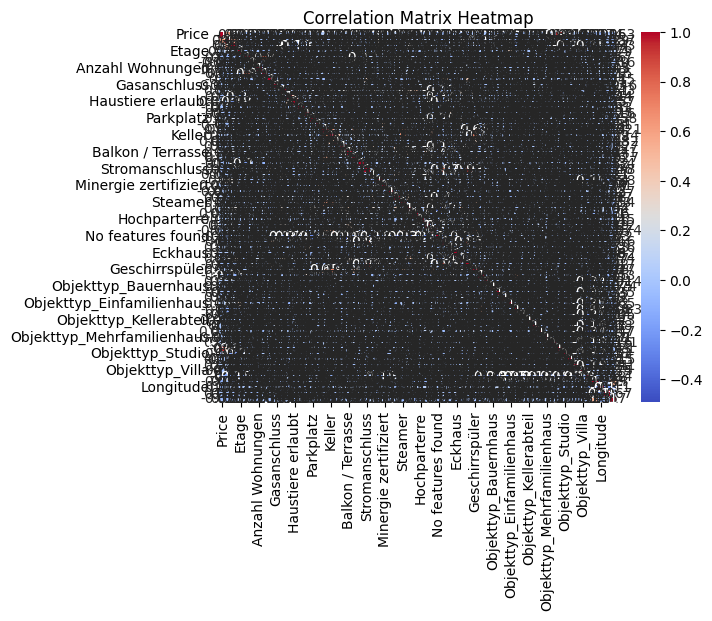

In [8]:
# create heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

**Wait** - can we do that with the booleans? 

Let's try the numeric values only:

In [9]:
df_complete_num = df_complete.select_dtypes(include=[np.number])
df_complete_not_num = df_complete.select_dtypes(exclude=[np.number])
correlation_matrix = df_complete_num.corr()
correlation_matrix['Price'].sort_values(ascending=False)

Price                      1.000000
Rooms                      0.601906
SquareMeters               0.196403
Etage                      0.050152
Raumhöhe                   0.031929
DistanceToStationKM        0.016078
Anzahl Wohnungen          -0.008176
Anzahl Toiletten          -0.020118
Baujahr                   -0.038819
Weather                   -0.052691
Letztes Renovationsjahr   -0.054533
Longitude                 -0.073510
Latitude                  -0.098525
Name: Price, dtype: float64

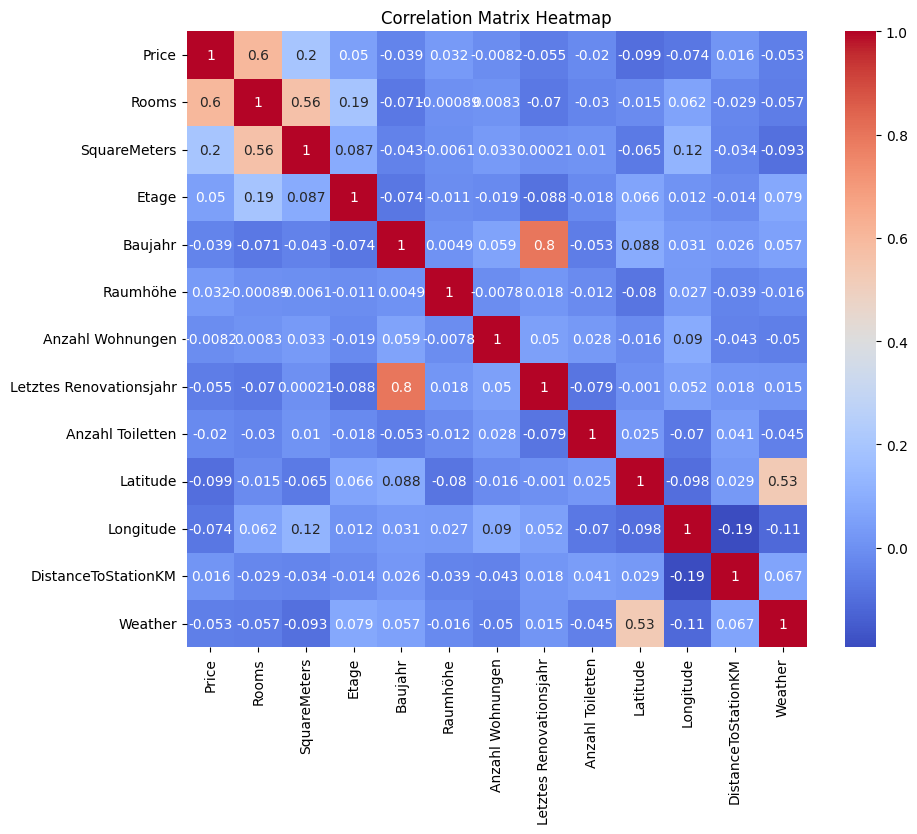

In [10]:
# create heatmap
plt.figure(figsize=(10, 8))  # Adjust the figure size as per your preference
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

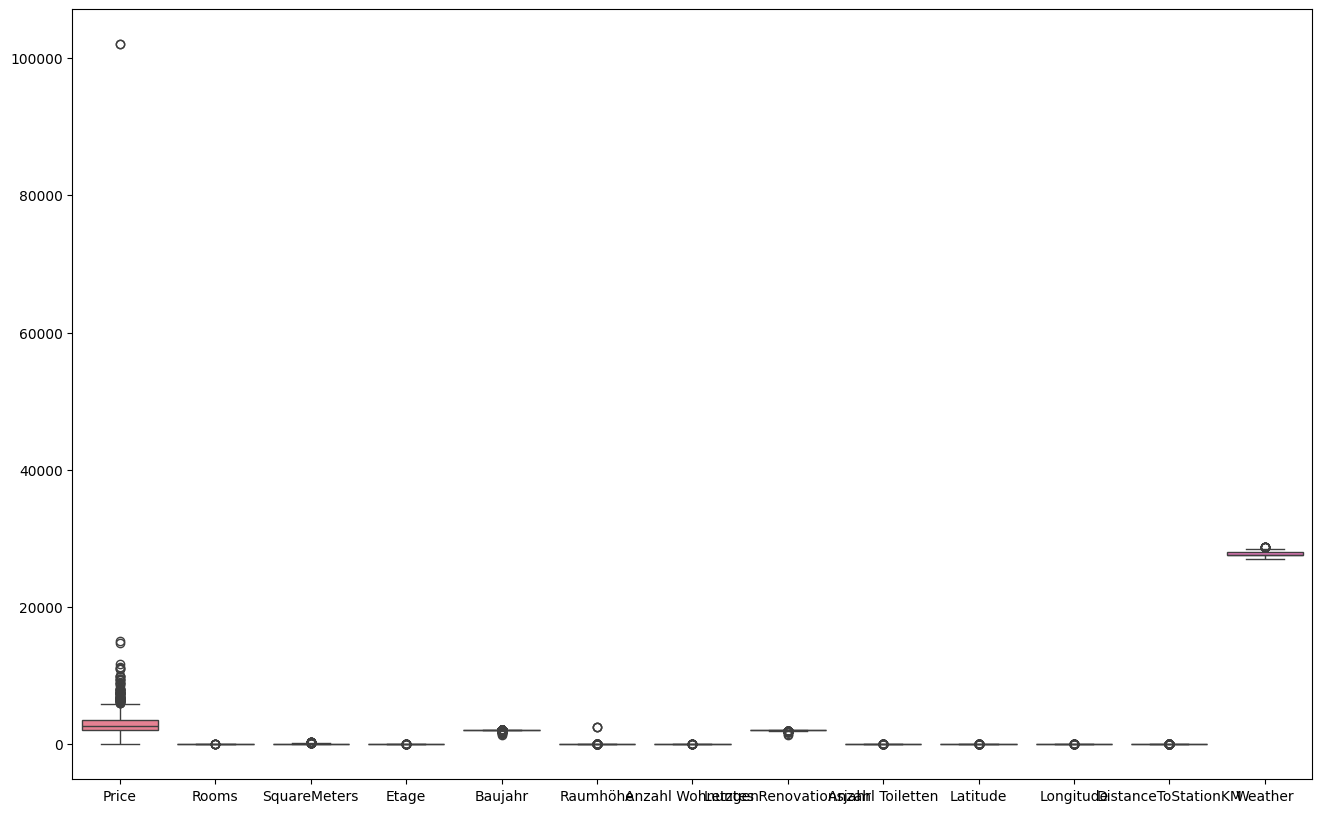

In [11]:
# Create a boxplot for each numerical feature
plt.figure(figsize=(16, 10))
sns.boxplot(data=df_complete_num)

# Show the plot
plt.show()

### Filter data with no value

In [12]:
# if needed we can drop the columns with a bad correlation here

### Feature Scaling 
With few exceptions, Machine Learning algorithms do not perform well when the scales of the input numerical attributes differ significantly. This is the situation with our data: the number of rooms spans from 1 to 20, and the prices range from 60.- to 102'000.-.

There are two popular ways to bring the attributes to the same scale: 
1. Min-max scaling 
    - Min-max scaling, often referred to as normalization, involves adjusting values to fall within a 0 to 1 range.
    - This scaling is achieved by subtracting the minimum value of the data and dividing by the range (max value minus min value).
    - Scikit-Learn offers a `MinMaxScaler` transformer specifically for this purpose.
    - The `MinMaxScaler` includes a `feature_range` hyperparameter that allows customization of the target range beyond the default 0 to 1.
2. Standardization
    - Standardization involves subtracting the mean and dividing by the variance to achieve zero mean and unit variance.
    - It does not limit values to a specific range, unlike min-max scaling, which may affect algorithms like neural networks because they expect a value between 0-1.
    - Standardization is less sensitive to outliers compared to min-max scaling.
    - Scikit-Learn offers a `StandardScaler` transformer for applying standardization.

> Géron (2017)

##### Our decision:
We believe that all values should ideally fall within a range between `0` and `1`. This is why we have decided to use the `MinMaxScaler.

In [13]:
df_complete_num.describe()

,Price,Rooms,SquareMeters,Etage,Baujahr,Raumhöhe,Anzahl Wohnungen,Letztes Renovationsjahr,Anzahl Toiletten,Latitude,Longitude,DistanceToStationKM,Weather
count,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000
mean,3346.142132,3.548088,87.444670,2.297462,2002.176650,10.275685,0.158376,2009.349239,0.047716,47.389907,8.592944,1.768055,27673.448342
std,4785.682250,1.536730,49.234766,8.547324,43.028602,140.838930,1.121344,36.008805,0.213272,0.082502,0.115268,1.181686,316.011091
min,60.000000,1.000000,10.000000,-2.000000,1357.000000,0.000000,0.000000,1357.000000,0.000000,47.202984,8.373245,0.041289,26981.000412
25%,2066.000000,2.500000,58.000000,0.000000,2013.000000,2.500000,0.000000,2013.000000,0.000000,47.352562,8.525842,1.061881,27526.156868
50%,2700.000000,3.500000,80.000000,1.000000,2013.000000,2.500000,0.000000,2013.000000,0.000000,47.381378,8.551206,1.491088,27619.227143
75%,3600.000000,4.500000,106.000000,2.000000,2013.000000,2.500000,0.000000,2022.000000,0.000000,47.429681,8.654411,2.112200,27976.696621
max,102000.000000,20.000000,400.000000,99.000000,2025.000000,2572.000000,14.000000,2025.000000,1.000000,47.692142,8.915707,6.424753,28686.442005


In [14]:
from sklearn.preprocessing import minmax_scale
df_complete_num_scaled = pd.DataFrame(minmax_scale(df_complete_num), columns=df_complete_num.columns)
df_complete_num_scaled.describe() 

,Price,Rooms,SquareMeters,Etage,Baujahr,Raumhöhe,Anzahl Wohnungen,Letztes Renovationsjahr,Anzahl Toiletten,Latitude,Longitude,DistanceToStationKM,Weather
count,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000
mean,0.032236,0.134110,0.198576,0.042549,0.965833,0.003995,0.011313,0.976571,0.047716,0.382132,0.405004,0.270506,0.406023
std,0.046946,0.080881,0.126243,0.084627,0.064414,0.054759,0.080096,0.053905,0.213272,0.168661,0.212490,0.185117,0.185296
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.019678,0.078947,0.123077,0.019802,0.982036,0.000972,0.000000,0.982036,0.000000,0.305786,0.281304,0.159881,0.319657
50%,0.025898,0.131579,0.179487,0.029703,0.982036,0.000972,0.000000,0.982036,0.000000,0.364696,0.328061,0.227118,0.374230
75%,0.034726,0.184211,0.246154,0.039604,0.982036,0.000972,0.000000,0.995509,0.000000,0.463443,0.518315,0.324418,0.583835
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Now it makes more sense to look at the boxplots than before.

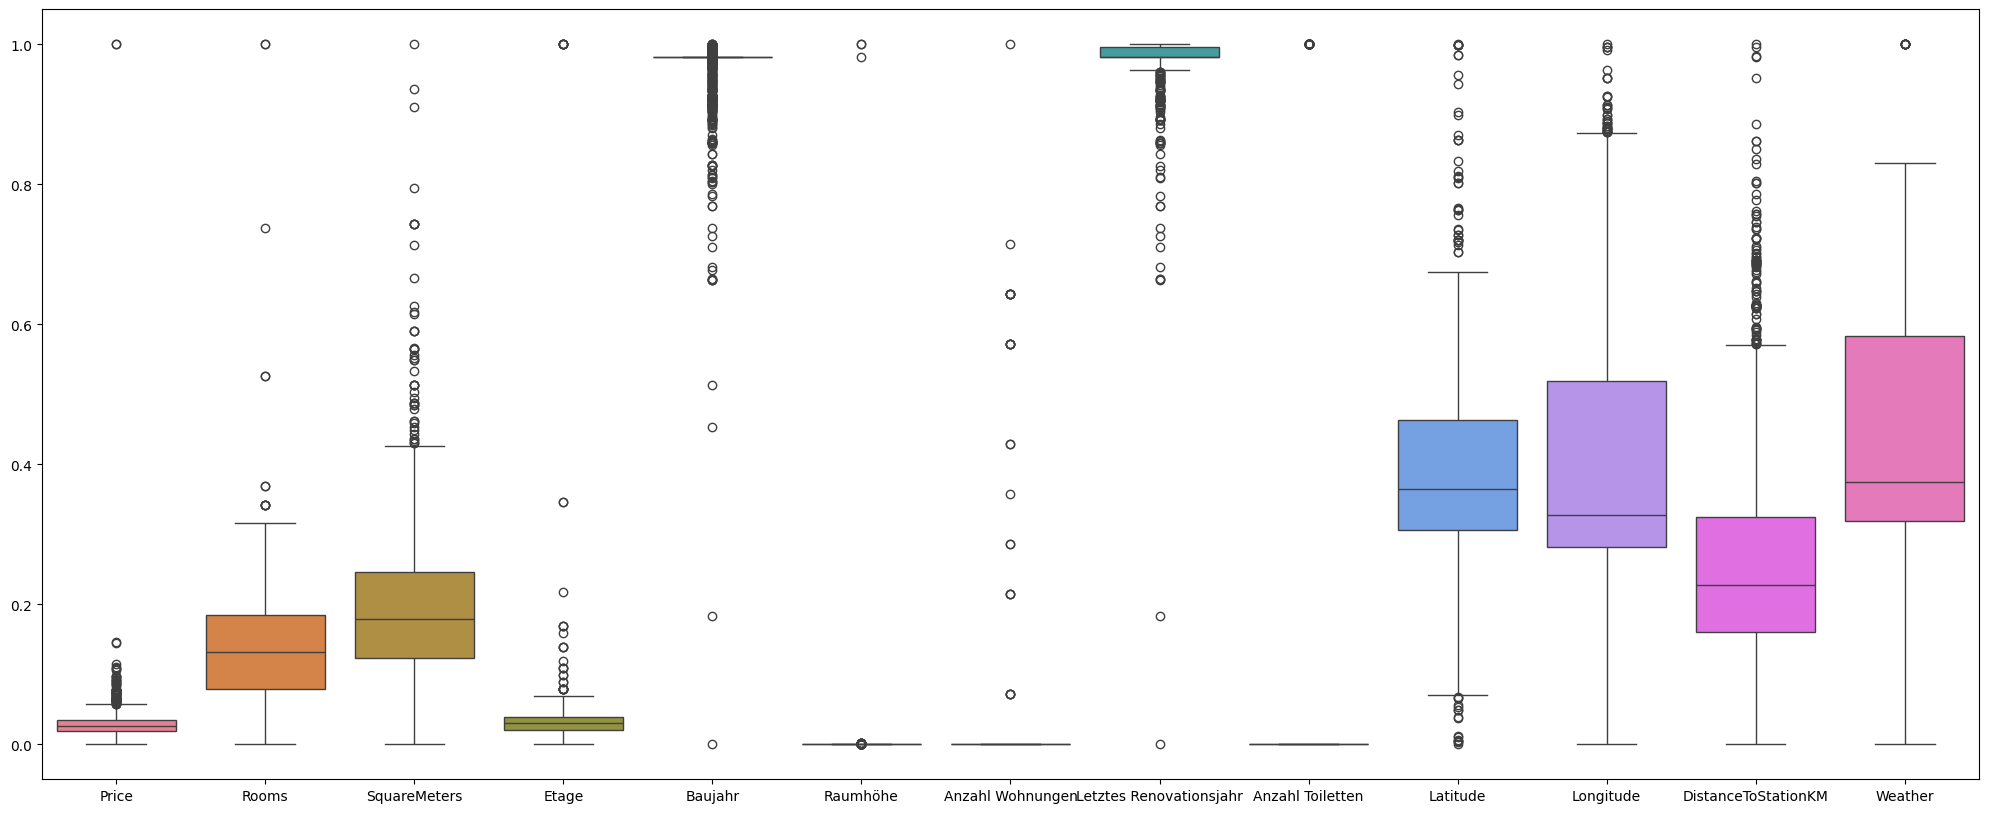

In [17]:
# Create a boxplot for each numerical feature
plt.figure(figsize=(25, 10))
sns.boxplot(data=df_complete_num_scaled)

# Show the plot
plt.show()

In [76]:
#redo the correlation matrix
correlation_matrix_scaled = df_complete_num.corr()
correlation_matrix_scaled['Price'].sort_values(ascending=False)

Price                      1.000000
Rooms                      0.601906
SquareMeters               0.196403
Etage                      0.050152
Raumhöhe                   0.031929
DistanceToStationKM        0.016078
Anzahl Wohnungen          -0.008176
Anzahl Toiletten          -0.020118
Baujahr                   -0.038819
Weather                   -0.052691
Letztes Renovationsjahr   -0.054533
Longitude                 -0.073510
Latitude                  -0.098525
Name: Price, dtype: float64

In [77]:
df_complete_scaled = pd.concat([df_complete_num_scaled, df_complete_not_num], axis=1)
df_complete_scaled.to_csv('immoscout24_zh_complete_scaled.csv', index=False, sep=';')
df_complete_scaled.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 985 entries, 0 to 984
Data columns (total 66 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Price                            985 non-null    float64
 1   Rooms                            985 non-null    float64
 2   SquareMeters                     985 non-null    float64
 3   Etage                            985 non-null    float64
 4   Baujahr                          985 non-null    float64
 5   Raumhöhe                         985 non-null    float64
 6   Anzahl Wohnungen                 985 non-null    float64
 7   Letztes Renovationsjahr          985 non-null    float64
 8   Anzahl Toiletten                 985 non-null    float64
 9   Latitude                         985 non-null    float64
 10  Longitude                        985 non-null    float64
 11  DistanceToStationKM              985 non-null    float64
 12  Weather               

## Prepear the data

Before starting modeling we have to prepear the dataset accordingly. We have to split into train and test set. However for most of the models it is needed that label (y) and features (X) are separated as well. 


- Split X/y (Feature and Label)
    - `X_train = train_data.loc[:,train_data.columns != "Price"]`
- Train/Test Split
    - 70/30

In [78]:
df_complete_scaled = pd.read_csv('immoscout24_zh_complete_scaled.csv', sep=';')
X = df_complete_scaled.drop(columns=['Price'])
y = df_complete_scaled['Price']
X.shape, y.shape

((985, 65), (985,))

In [79]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, y_train.shape

((788, 65), (788,))

In [80]:
X_test.shape, y_test.shape

((197, 65), (197,))

# Modeling
## Choose Model(s)
For our regression problem, we will evaluate and compare the following models to find the best fit for predicting house prices. The models include both linear and non-linear approaches to accommodate different patterns and complexities in the data.

### Models to Evaluate
1. **Random Forest Regressor**
   - A robust ensemble model that uses multiple decision trees to produce a more stable and accurate prediction. It's generally good at handling outliers and non-linear data.
   - Import with: `from sklearn.ensemble import RandomForestRegressor`
   <br><img src="resources\Random-Forest-Regressor.png" width="400">
   <br><small>[Image Source](https://www.researchgate.net/figure/Fig-A10-Random-Forest-Regressor-The-regressor-used-here-is-formed-of-100-trees-and-the_fig3_313489088), Retrieved March 29, 2024</small>


2. **Linear Regression**
   - A simple yet powerful model that assumes a linear relationship between input variables and the target. It's effective when the relationship is linear and is easy to interpret.
   - Import with: `from sklearn.linear_model import LinearRegression`    
   <img src="resources\linear-regression.png" width="400">
   <br><small>[Image Source](https://towardsdatascience.com/linear-regression-using-python-b136c91bf0a2), Retrieved March 29, 2024</small>

3. **Neural Network (NN) Model using TensorFlow**
   - A highly flexible and powerful model capable of modeling complex non-linear relationships. Neural networks are particularly useful when we have a large amount of data and the relationship between variables is complex.
   - Implemented using TensorFlow, which provides the tools to build custom neural network architectures.
   <br><img src="resources\nn.png" width="400">
   <br><small>[Image Source](https://medium.com/deepviz/explainable-ai-and-visual-interpretability-dawn-of-neural-networks-part-5-b302e7d85650), Retrieved March 29, 2024</small>

## Train Model
Each model will be trained using the same set of training data. This allows for a fair comparison between models based on their performance metrics.

- **Data Split**: Split the data into training and validation sets to evaluate the model's performance.
- **Training Process**: Fit each model to the training data using their respective training algorithms.

### Linear Regression

In [81]:
# Linear Regression
from sklearn.linear_model import LinearRegression

# Create a Linear Regression model
model = LinearRegression()

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Evaluate the model
from sklearn.metrics import mean_squared_error, r2_score

# Calculate the Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calculate the Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Calculate the R-squared value
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse:.2f}, Root Mean Squared Error: {rmse:.2f}, R-squared: {r2:.2f}')



Mean Squared Error: 0.00, Root Mean Squared Error: 0.01, R-squared: 0.54


Not too bad! A good model will have a low MSE and RMSE and a high R-squared value.

---
### Decision Tree

In [82]:
# Decision Tree Regressor / Random Forest Regressor
from sklearn.tree import DecisionTreeRegressor

# Create a Decision Tree Regressor model
model = DecisionTreeRegressor()

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Calculate the Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calculate the Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Calculate the R-squared value
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse:.2f}, Root Mean Squared Error: {rmse:.2f}, R-squared: {r2:.2f}')


Mean Squared Error: 0.00, Root Mean Squared Error: 0.01, R-squared: 0.30


A bit lower than Linear Regressor. What if we add some complexity in the next step?

---
### Random Forest Regressor

In [83]:
from sklearn.ensemble import RandomForestRegressor 

# Create a Random Forest Regressor model
model = RandomForestRegressor()

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Calculate the Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calculate the Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Calculate the R-squared value
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse:.2f}, Root Mean Squared Error: {rmse:.2f}, R-squared: {r2:.2f}')

Mean Squared Error: 0.00, Root Mean Squared Error: 0.01, R-squared: 0.71


Highest R-squared so far. Let's try a fancy Regression with a NN.

---
### Neural Network Regressor 

We will use Keras to build a simple neural network. There are some choices that have to be done regarding the model parameters:
1. Input Layer: The size (128 neurons) is chosen to be sufficiently large to capture the complexity from 65 input features. However, we do not want to choose a too large input layer sice on order to avoid overfitting.
2. Hidden Layers: We choose two additional hidden layers with decreasing sizes (64 and 32 neurons) to create a funnel-like structure, which is helping the network to learn more abstract representations in a hierarchical manner.
3. Activation Function: The choice is the relu-function (Rectified Linear Unit). It is used because it performs well in avoiding the vanishing gradient problem and shal be effective in regression tasks.
4. Output Layer: The output layer has a single neuron, as it's a regression task (predicting a continuous value). The default linear activation function (None) is appropriate here.
5. Optimizer: 'Adam' is chosen as it's an effective and popular choice for many types of neural networks. It adjusts the learning rate during training.
6. Loss Function: 'MSE' (Mean Squared Error) is used for regression problems as it effectively captures the average squared difference between the predicted and actual values.

In [85]:
# Neural Network Regressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Initialize the model
model = Sequential([
    Dense(128, activation='relu', input_shape=(65,)),  # Input layer with 65 features and ReLU activation
    Dense(64, activation='relu'),                      # Hidden layer with 64 neurons
    Dense(32, activation='relu'),                      # Further condensed hidden layer
    Dense(1)                                           # Output layer with 1 neuron for regression
])

In [86]:
model.compile(
    optimizer='adam',            # Efficient optimization algorithm
    loss='mse',                  # Mean Squared Error for regression
    metrics=['mae']              # Mean Absolute Error for performance monitoring
)

In [88]:
history = model.fit(X_train.astype(float), y_train.astype(float), epochs=100, batch_size=32, validation_split=0.2)


Epoch 1/100


20/20 [==============================] - 2s 14ms/step - loss: 0.0093 - mae: 0.0722 - val_loss: 0.0146 - val_mae: 0.0534
Epoch 2/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0015 - mae: 0.0300 - val_loss: 0.0132 - val_mae: 0.0366
Epoch 3/100
20/20 [==============================] - 0s 4ms/step - loss: 7.1372e-04 - mae: 0.0210 - val_loss: 0.0129 - val_mae: 0.0332
Epoch 4/100
20/20 [==============================] - 0s 4ms/step - loss: 4.5192e-04 - mae: 0.0162 - val_loss: 0.0127 - val_mae: 0.0309
Epoch 5/100
20/20 [==============================] - 0s 4ms/step - loss: 3.2386e-04 - mae: 0.0135 - val_loss: 0.0125 - val_mae: 0.0293
Epoch 6/100
20/20 [==============================] - 0s 7ms/step - loss: 2.5397e-04 - mae: 0.0117 - val_loss: 0.0125 - val_mae: 0.0285
Epoch 7/100
20/20 [==============================] - 0s 5ms/step - loss: 2.0686e-04 - mae: 0.0105 - val_loss: 0.0123 - val_mae: 0.0280
Epoch 8/100
20/20 [==============================] - 0s 12ms

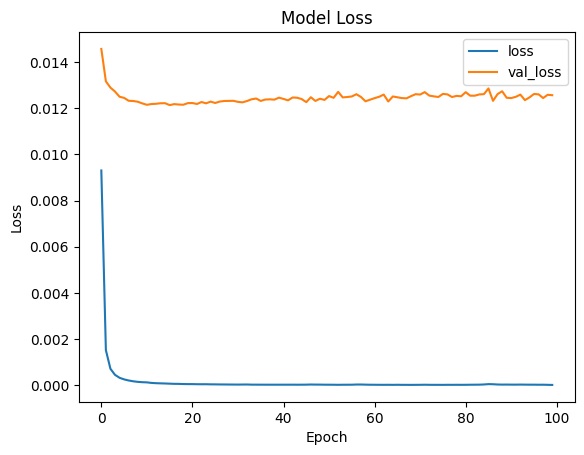

In [90]:
# Plot the training and validation loss
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [94]:
loss, mae = model.evaluate(X_test.astype(float), y_test.astype(float))
print(f"Test Loss: {loss}, Test MAE: {mae}")

7/7 [==============================] - 0s 2ms/step - loss: 4.5414e-04 - mae: 0.0140
Test Loss: 0.00045413649058900774, Test MAE: 0.013977891765534878
9.041620533200319e-05


In [95]:
y_pred = model.predict(X_test.astype(float))

# Calculate the Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calculate the Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Calculate the R-squared value
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse:.2f}, Root Mean Squared Error: {rmse:.2f}, R-squared: {r2:.2f}')

7/7 [==============================] - 0s 0s/step
Mean Squared Error: 0.00, Root Mean Squared Error: 0.02, R-squared: -0.43


# Model Evaluation
## Model Evaluation
Evaluate the performance of each model using the following criteria to ensure robustness and reliability:

- **Validation Techniques**: Implement cross-validation techniques such as K-fold cross-validation to validate the consistency and robustness of each model's performance across different subsets of the data.
- **Performance Metrics**: Assess the model using regression-specific metrics including:
  - RMSE (Root Mean Square Error): Measures the average magnitude of the errors in a set of predictions, without considering their direction. It’s particularly useful to compare prediction errors of different models and datasets.
  - MAE (Mean Absolute Error): Provides a measure of errors between paired observations expressing the same phenomenon.
  - R² (Coefficient of Determination): Indicates the proportion of the variance in the dependent variable that is predictable from the independent variables.
- **Iterate**: Based on the performance metrics, refine and iterate on the model's parameters to enhance prediction accuracy and align the model more closely with business needs.


## Model Selection
The final model selection will be based on a combination of performance metrics and the model's ability to generalize to unseen data. We aim to choose a model that not only performs well but also provides the right balance of complexity and interpretability suited for our use case.



In [ ]:
# to do at the very end: freeze the requirements in a requirements.txt file with the command: pip freeze > requirements.txt and load the requirements with the command: pip install -r requirements.txt at the top of the script

### Meteo

In [26]:
# the command with the % will install the libraries directly in the correct enviroment
%pip install openmeteo-requests
%pip install requests-cache retry-requests numpy pandas

  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 23.5.26
    Uninstalling flatbuffers-23.5.26:
      Successfully uninstalled flatbuffers-23.5.26
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 1.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 1.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [27]:
import openmeteo_requests

import requests_cache
import pandas as pd
from retry_requests import retry

In [28]:
import openmeteo_requests

import matplotlib.pyplot as plt
import requests_cache
import pandas as pd
from retry_requests import retry

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": latitude,
	"longitude": longitude,
	"start_date": "2024-03-01",
	"end_date": "2024-03-17",
	"daily": ["temperature_2m_mean", "sunshine_duration", "rain_sum"],
	"timezone": "Europe/Berlin"
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")



# Process daily data. The order of variables needs to be the same as requested.
daily = response.Daily()
daily_temperature_2m_mean = daily.Variables(0).ValuesAsNumpy()
daily_sunshine_duration = daily.Variables(1).ValuesAsNumpy()
daily_rain_sum = daily.Variables(2).ValuesAsNumpy()

daily_data = {"date": pd.date_range(
	start = pd.to_datetime(daily.Time(), unit = "s", utc = True),
	end = pd.to_datetime(daily.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = daily.Interval()),
	inclusive = "left"
)}
daily_data["temperature_2m_mean"] = daily_temperature_2m_mean
daily_data["sunshine_duration"] = daily_sunshine_duration /3600
daily_data["rain_sum"] = daily_rain_sum

daily_dataframe = pd.DataFrame(data = daily_data)
print(daily_dataframe)

# Plotting
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Date')
plt.xticks(rotation=45)
ax1.set_ylabel('Temperature (°C)', color=color)
ax1.plot(daily_dataframe['date'], daily_dataframe['temperature_2m_mean'], color=color, label='Temperature')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Sunshine Duration (hours)', color=color)
ax2.plot(daily_dataframe['date'], daily_dataframe['sunshine_duration'], color=color, label='Sunshine Duration')
ax2.tick_params(axis='y', labelcolor=color)

ax3 = ax1.twinx()  # instantiate a third axes for the rain sum
ax3.spines['right'].set_position(('outward', 60))  # Offset the right spine of ax3
color = 'tab:green'
ax3.set_ylabel('Rain Sum (mm)', color= "blue")
ax3.bar(daily_dataframe['date'], daily_dataframe['rain_sum'], color="blue", label='Rain Sum', alpha=0.5, width=0.5)
ax3.tick_params(axis='y', labelcolor="blue")

# Otherwise the right y-label is slightly clipped
fig.tight_layout()
plt.title('Weather Data Analysis')
plt.show()


NameError: name 'latitude' is not defined

In [ ]:
#Because my lovely group doesn't recognise my amazing work, I've finally implemented a clickable and interactive graph with Plotly.

In [ ]:
#install the following environment via your terminal.

#pip install plotly

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd

# Assuming daily_dataframe is already created as per your Matplotlib example

# Create a subplot with 2 y-axes on the left and 1 y-axis on the right
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add temperature plot on primary y-axis
fig.add_trace(
    go.Scatter(x=daily_dataframe['date'], y=daily_dataframe['temperature_2m_mean'],
               name='Temperature (°C)', mode='lines', line=dict(color='red')),
    secondary_y=False,
)

# Add sunshine duration plot on secondary y-axis (left)
fig.add_trace(
    go.Scatter(x=daily_dataframe['date'], y=daily_dataframe['sunshine_duration'],
               name='Sunshine Duration (hours)', mode='lines', line=dict(color='blue')),
    secondary_y=True,
)

# Since Plotly does not directly support a third y-axis, we use a bar chart to represent the rain sum
# This will overlay on the primary y-axis but can be visually distinguished
fig.add_trace(
    go.Bar(x=daily_dataframe['date'], y=daily_dataframe['rain_sum'],
           name='Rain Sum (mm)', marker_color='green', opacity=0.5),
    secondary_y=False,
)

# Set x-axis title
fig.update_xaxes(title_text="Date")

# Set y-axes titles
fig.update_yaxes(title_text="Temperature (°C)", secondary_y=False, color='red')
fig.update_yaxes(title_text="Sunshine Duration (hours)", secondary_y=True, color='blue')

# Set layout options
fig.update_layout(
    title_text="Weather Data Analysis",
    xaxis_tickangle=-45,
    legend=dict(orientation="h"),
)

# Show plot
fig.show()


In [ ]:
#I hope my team is happy now.

# Quellen:
- Géron, A. (2017). Hands-On Machine Learning with Scikit-Learn and TensorFlow: Techniques and Tools to Build Learning Machines. O’Reilly Media.

# Jupyter notebook --footer info--

In [84]:
import os
import platform
import socket
from platform import python_version
from datetime import datetime

print('-----------------------------------')
print(os.name.upper())
print(platform.system(), '|', platform.release())
print('Datetime:', datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
print('Python Version:', python_version())
print('-----------------------------------')

-----------------------------------
NT
Windows | 10
Datetime: 2024-04-29 21:40:10
Python Version: 3.11.7
-----------------------------------
